# Diet Data Editor
Author: Brent Artuch <br>
Date: 2023-06-04

## Introduction

This notebook depicts the process of adding new food entries to my SQLite database and then takes you
through the macronutrient conversion calculations. After the caloric intake based on macro nutrient for
the day has been calculated, we then proceed to a few visualizations for those calculations. <br>

This document utilizes an array of Pandas processing techniques such as filtering via boolean masking,
using descriptive methods to illustrate the shape of the data set, and creating visualizations using the
data in the dataframe.

## Step: 1 Imports
### Import packages

In [0]:
import sqlite3
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Load the dataset
This dataset is pulled from a SQLite database that stores all foods I have consumed by `month`. We will
load the current month using a simple query.

In [1]:
sql_connection = sqlite3.connect('diet.sqlite')
# Import desired table and set the index to id.
current_foods = pd.read_sql('SELECT * FROM june_2023', sql_connection, index_col='index')
current_foods.tail(10)

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
15,1000249,2023-06-02 00:00:00,4,Protein Powder,1.0,3.0,2.0,24,120
16,1000250,2023-06-02 00:00:00,4,Ice Cream,3.0,23.0,9.0,3,180
17,1000251,2023-06-02 00:00:00,4,Pop Tart,1.0,74.0,9.0,3,390
18,1000252,2023-06-03 00:00:00,1,Pizza Slice,1.0,42.0,10.0,19,330
19,1000253,2023-06-03 00:00:00,2,Steak Ques.,1.0,42.0,27.0,26,520
20,1000254,2023-06-03 00:00:00,2,Wendys Jr Fries,2.0,28.0,9.0,3,210
21,1000255,2023-06-03 00:00:00,2,Nacho Bellgrande,1.0,81.0,38.0,17,730
22,1000256,2023-06-03 00:00:00,2,Protein Powder,2.0,3.0,2.0,24,120
23,1000257,2023-06-03 00:00:00,3,Rice Krispie,2.0,17.0,2.0,0,90


## Step 2: Data Exploration
Next we will get a sense of the size and contents of this new dataframe.

In [17]:
current_foods.shape

(27, 9)

In [18]:
current_foods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 26
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   food_id      27 non-null     int64         
 1   date         27 non-null     datetime64[ns]
 2   meal_number  27 non-null     int64         
 3   food_name    27 non-null     object        
 4   servings     27 non-null     float64       
 5   carbs        27 non-null     float64       
 6   fats         27 non-null     float64       
 7   protein      27 non-null     int64         
 8   calories     27 non-null     int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 2.1+ KB


In [19]:
current_foods[['carbs','fats','protein','calories']].describe()

,carbs,fats,protein,calories
count,27.000000,27.000000,27.000000,27.000000
mean,26.962963,10.037037,14.444444,253.185185
std,26.569910,16.839700,14.121270,277.222632
min,1.000000,0.000000,0.000000,70.000000
25%,3.000000,2.000000,2.000000,120.000000
50%,22.000000,3.000000,17.000000,130.000000
75%,42.000000,10.000000,24.000000,330.000000
max,98.000000,81.000000,63.000000,1400.000000


In [20]:
current_foods['food_name'].value_counts()

Protein Powder      8
Pizza Slice         3
Fruit Snacks        2
Ramen               1
Gatorade Powder     1
Nacho Bellgrande    1
Wendys Jr Fries     1
Steak Ques.         1
Pop Tart            1
Ice Cream           1
Rice                1
Ranch               1
Spicy Garlic        1
Cereal Bar          1
Oatmeal             1
Voodoo Pasta        1
Rice Krispie        1
Name: food_name, dtype: int64

## Step 3: Update the Dataset
### Load the master food list
First we will load the names of the foods from the master `food_list` database so that the algorithm
can check against the list for whether the food reference exists.

In [6]:
# Call the master food list.
food_db = pd.read_sql('SELECT food_name FROM food_list', sql_connection)
food_db.head()

,food_name
0,Oatmeal
1,Protein Powder
2,Coco Powder
3,Ramen
4,Cereal Bar


### Set the date of the entries

In [7]:
day_of_month = input("Enter the day of the month: DD")
date = f"2023-06-{day_of_month} 00:00:00"
date

'2023-06-03 00:00:00'

### Execute the entry insertion algorithm

In [8]:
# Set the current meal number to be logged
choice = 1
foods = list(food_db['food_name'])

while choice != 2:

    """ This algorithm takes a desired food input and then inserts it into a SQL query to
    retrieve the nutritional info for that food. The meal number and serving count are
     updated and then the entry is inserted into the dataframe. """

    db_food = input("What food would you like too add?")
    if db_food not in foods:
        raise Exception(input("Food not in database. Try again: "))
    new_food = pd.read_sql("SELECT food_name, carbs, fats, protein, calories"
                            " FROM food_list "
                            " WHERE food_name = (?)", sql_connection, params=(db_food,))
    meal_number = int(input("Enter Meal Number: "))
    servings = float(input("Enter Serving Count: "))
    f_id = current_foods.iloc[-1, 0] + 1
    new_entry = [f_id,
                 date,
                 meal_number,
                 new_food.loc[0,'food_name'],
                 servings,
                 new_food.loc[0,'carbs'],
                 new_food.loc[0,'fats'],
                 new_food.loc[0,'protein'],
                 new_food.loc[0,'calories']]
    current_foods.loc[len(current_foods)] = new_entry
    choice = int(input("Add another? [1]Yes [2]No"))

current_foods['date'] = pd.to_datetime(current_foods['date'])
updated_foods = current_foods
updated_foods.tail()

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
22,1000256,2023-06-03,2,Protein Powder,2.0,3.0,2.0,24,120
23,1000257,2023-06-03,3,Rice Krispie,2.0,17.0,2.0,0,90
24,1000258,2023-06-03,3,Protein Powder,2.0,3.0,2.0,24,120
25,1000259,2023-06-03,4,Fruit Snacks,1.0,17.0,0.0,1,70
26,1000260,2023-06-03,4,Protein Powder,2.0,3.0,2.0,24,120


### Data Manipulation
This section exists for convenience if quick changes need to be made to the entries.

In [ ]:
# Update item(s) by index and column
# current_foods.loc[227,'servings'] = 2.0
# Drop operation
# current_foods.drop(index=current_foods.index[-1], axis=0, inplace=True) # Remove last entry
updated_foods.tail()

### Update SQL
Now that we have updated our table, we will export the new dataset to SQL. As a precaution, I always
back up the new dataset to CSV through the SQL workbench in the event that an older version is required
in the future.

In [9]:
updated_foods.to_sql('june_2023', sql_connection, if_exists='replace')

# TODO: MANUALLY REVIEW SQL AND EXPORT NEW TABLE TO CSV AS BACKUP!!

27

## Step 4: Daily Macro Calculations
### Filter out all entries besides those with today's date.

In [10]:
# Sort entries by date
mask = updated_foods['date'] == date
today = updated_foods.loc[mask]
today

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
18,1000252,2023-06-03,1,Pizza Slice,1.0,42.0,10.0,19,330
19,1000253,2023-06-03,2,Steak Ques.,1.0,42.0,27.0,26,520
20,1000254,2023-06-03,2,Wendys Jr Fries,2.0,28.0,9.0,3,210
21,1000255,2023-06-03,2,Nacho Bellgrande,1.0,81.0,38.0,17,730
22,1000256,2023-06-03,2,Protein Powder,2.0,3.0,2.0,24,120
23,1000257,2023-06-03,3,Rice Krispie,2.0,17.0,2.0,0,90
24,1000258,2023-06-03,3,Protein Powder,2.0,3.0,2.0,24,120
25,1000259,2023-06-03,4,Fruit Snacks,1.0,17.0,0.0,1,70
26,1000260,2023-06-03,4,Protein Powder,2.0,3.0,2.0,24,120


### Macro Calculations
These calculations assist in assessing the required macro nutrients for the day and possible adjustments
that need to made if carbs or fats have exceeded or come up short of their targets.

In [11]:
# Calculate macronutrient totals based on serving count
total_carbs = int((today['carbs'] * today['servings']).sum())
total_fats = int((today['fats'] * today['servings']).sum())
total_protein = int((today['protein'] * today['servings']).sum())
total_cals = int((today['calories'] * today['servings']).sum())

print(f"Carbs: {total_carbs} | Goals: 500 400 300")
print(f"Fats: {total_fats} | Goals: 100 75 50")
print(f"Protein: {total_protein} | Goal: 200")
print(f"Calories: {total_cals}")

Carbs: 290 | Goals: 500 400 300
Fats: 109 | Goals: 100 75 50
Protein: 213 | Goal: 200
Calories: 2970


### Convert the macro nutrients to their caloric measurement.

In [12]:
# Calculate the number of calories from each macro nutrient.
carb_cals = total_carbs * 4
fat_cals = total_fats * 9
protein_cals = total_protein * 4

print(f"Calories Form Carbs: {carb_cals}")
print(f"Calories Form Fats: {fat_cals}")
print(f"Calories Form Protein: {protein_cals}")

Calories Form Carbs: 1160
Calories Form Fats: 981
Calories Form Protein: 852


## Step 5: Visualize the Data
### Portray the macro nutrient dispersion of calories as a pie chart.

<Axes: ylabel='Macro Breakdown'>

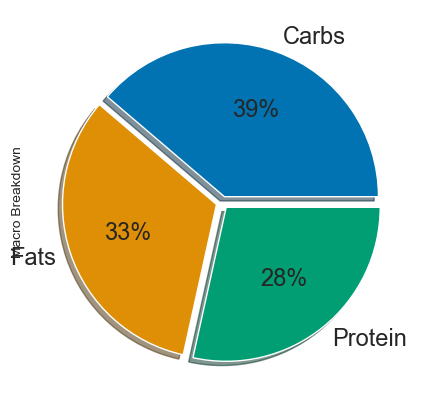

In [13]:
# Plot as a pie chart
macro_series = pd.Series(
    [carb_cals, fat_cals, protein_cals],
    index=['Carbs', 'Fats', 'Protein'],
    name="Macro Breakdown"
)

macro_series.plot.pie(
    colors=sns.color_palette('colorblind'),
    autopct='%1.0f%%',
    fontsize=17,
    shadow=True,
    explode=(0.04,0.04,0.04),
    figsize=(5,5)
)

### Add a new `total_food_cals` column that is the product of the food entry servings by its `calories`.

In [14]:
# Add a total calories column
today.loc[:,'total_food_cals'] = today.loc[:,'servings'] * today.loc[:,'calories'] # Combine columns
today

/var/folders/6l/g3r9cy7524bc08xq768fxvq40000gn/T/ipykernel_4255/10959325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  today.loc[:,'total_food_cals'] = today.loc[:,'servings'] * today.loc[:,'calories'] # Combine columns


,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories,total_food_cals
index,,,,,,,,,,
18,1000252,2023-06-03,1,Pizza Slice,1.0,42.0,10.0,19,330,330.0
19,1000253,2023-06-03,2,Steak Ques.,1.0,42.0,27.0,26,520,520.0
20,1000254,2023-06-03,2,Wendys Jr Fries,2.0,28.0,9.0,3,210,420.0
21,1000255,2023-06-03,2,Nacho Bellgrande,1.0,81.0,38.0,17,730,730.0
22,1000256,2023-06-03,2,Protein Powder,2.0,3.0,2.0,24,120,240.0
23,1000257,2023-06-03,3,Rice Krispie,2.0,17.0,2.0,0,90,180.0
24,1000258,2023-06-03,3,Protein Powder,2.0,3.0,2.0,24,120,240.0
25,1000259,2023-06-03,4,Fruit Snacks,1.0,17.0,0.0,1,70,70.0
26,1000260,2023-06-03,4,Protein Powder,2.0,3.0,2.0,24,120,240.0


### Group the entries by `meal_number` and aggregate the corresponding `total_food_cals` to get `cals_per_meal`

In [15]:
cals_per_meal = today.groupby(today['meal_number']).aggregate({'total_food_cals': 'sum'})
cals_per_meal

,total_food_cals
meal_number,
1,330.0
2,1910.0
3,420.0
4,310.0


### Plot the calories per meal
Ideally the line should be as level as possible over four meals.

<Axes: title={'center': 'Calories Per Meal'}, xlabel='Meal Number', ylabel='Calorie Count'>

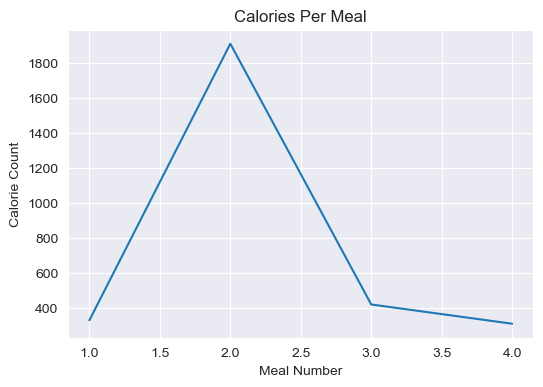

In [16]:
plt.figure(figsize=(6,4))
plt.title("Calories Per Meal")
plt.xlabel("Meal Number")
plt.ylabel("Calorie Count")

sns.lineplot(
    data=cals_per_meal,
    legend=False
)

## LOG:
### 2023-05-15: Wine removed from diet
### 2023-05-29: New Cal Goals 500 400 300